In [84]:
import pandas as pd

In [85]:
df = pd.read_csv("./Input/pesticide_use.csv", encoding = "cp1252")

/tmp/ipykernel_35679/2370551333.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./Input/pesticide_use.csv", encoding = "cp1252")


# Choice of unit = gram per International Dollar

In [86]:
df = df[df["Unit"] == "g/Int$"]

# Mean and Variance of g/Int$

In [87]:
continents_to_filter = ['Africa', 'Asia', 'Europe', 'Northern America', 'Central America', 'South America', 'Oceania']
filtered_df = df[df['Area'].isin(continents_to_filter)]

In [88]:
grouped_stats = filtered_df.groupby('Area')['Value'].agg(['mean', 'std'])
grouped_stats

,mean,std
Area,,
Africa,0.428438,0.063860
Asia,0.594688,0.065795
Central America,1.210000,0.181659
Europe,0.918750,0.049693
Northern America,1.332812,0.118872
Oceania,0.830000,0.186496
South America,1.707812,0.613976


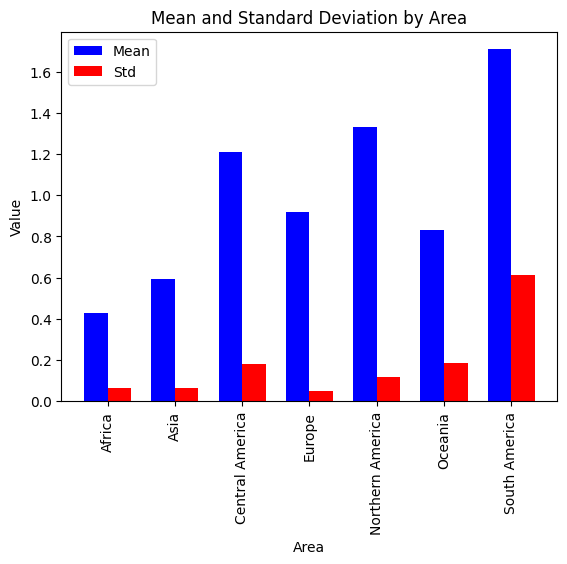

In [89]:
import matplotlib.pyplot as plt
df = grouped_stats

# Plotting grouped bar chart
fig, ax = plt.subplots()

# Set the width of each bar
bar_width = 0.35

# Set the positions of the bars on the x-axis
x = range(len(df))

# Plotting bars for mean
bars1 = ax.bar(x, df['mean'], width=bar_width, label='Mean', color='b')

# Plotting bars for standard deviation
bars2 = ax.bar([p + bar_width for p in x], df['std'], width=bar_width, label='Std', color='r')

# Labeling the x-axis ticks with area names
ax.set_xticks([p + bar_width / 2 for p in x])
ax.set_xticklabels(df.index, rotation=90)

# Adding labels, title, and legend
ax.set_xlabel('Area')
ax.set_ylabel('Value')
ax.set_title('Mean and Standard Deviation by Area')
ax.legend()

# Show the plot
plt.show()

# Trend analysis of 7 regions (1990-2021)

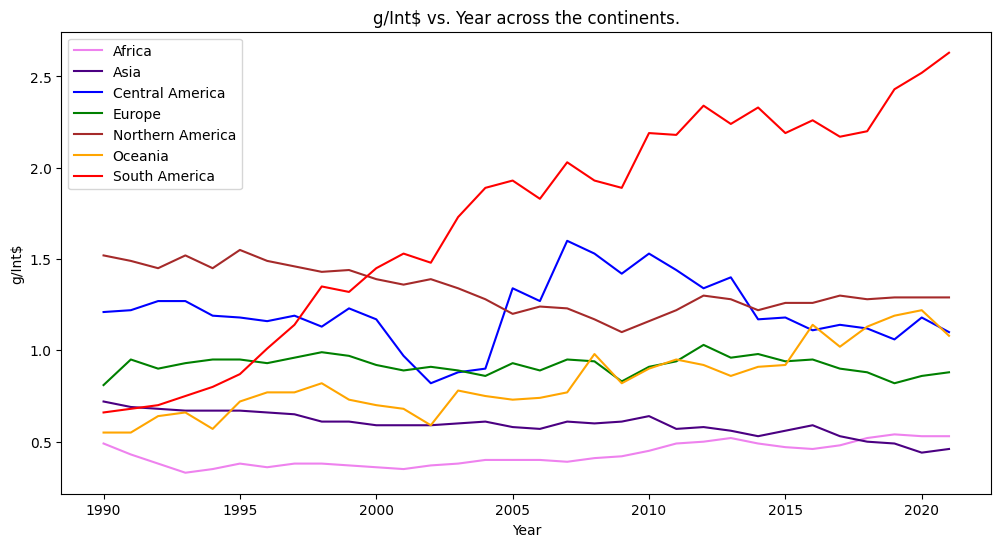

In [90]:
import matplotlib.pyplot as plt
groupedseries = filtered_df.groupby('Area')
listofdfs = [group for _, group in groupedseries]
colors = ['violet','indigo','blue','green','brown','orange','red']
plt.figure(figsize=[12,6])
for i in range(len(listofdfs)):
    temp = listofdfs[i]
    label = temp['Area'].unique()[0]
    plt.plot(
        temp['Year'],
        temp['Value'],
        marker = None,
        linestyle = '-',
        color = colors[i],
        label =label
    )
plt.xlabel('Year')
plt.ylabel('g/Int$')
plt.title('g/Int$ vs. Year across the continents.')
plt.legend()
plt.show()

In [91]:
from statsmodels.tsa.stattools import adfuller

# Step 1: check for stationarity of time-series

## Method 1: time series plot

In [92]:
traindfs = []
testdfs = []
for i in range(len(listofdfs)):
    traindfs.append(listofdfs[i].head(len(listofdfs[i])-1))
    testdfs.append(listofdfs[i].tail(1))

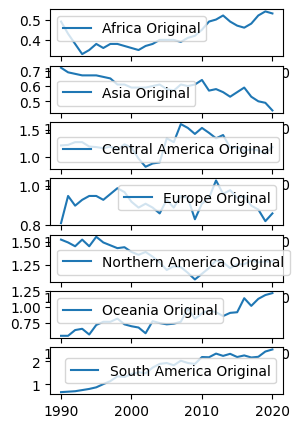

In [93]:
fig, axs = plt.subplots(len(listofdfs),1, figsize=(3,5))
for i in range(len(listofdfs)):
    temp = traindfs[i]
    label = temp['Area'].unique()[0]
    axs[i].plot(temp['Year'], temp['Value'], label = label +" "+ "Original")
    axs[i].legend()

In [94]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Method 3: ADF test

In [95]:
# The null hypothesis in the ADF test is: the time series is non-stationary
# If p < 0.5 we reject the null == the time series is non-stationary
# Let us see if we reject the null for all the seven time-series

In [96]:
from statsmodels.tsa.stattools import adfuller
for i in range(len(traindfs)): 
    temp = traindfs[i]
    label = temp['Area'].unique()[0]
    adf_test = adfuller(temp["Value"])
    print("p-value = "+str(adf_test[1]) + " for "+label)

p-value = 0.22387709578732895 for Africa
p-value = 0.8808034257898254 for Asia
p-value = 0.0451662891591232 for Central America
p-value = 0.0016448342414842848 for Europe
p-value = 0.44787654126717014 for Northern America
p-value = 0.9977472938234591 for Oceania
p-value = 0.06341469876717186 for South America


In [97]:
def find_d(timeseries, p_value):
    p = adfuller(timeseries)[1]
    if p < p_value:
        return 0
    return 1 + find_d(timeseries.diff().dropna(), p_value)

In [98]:
num_diffs = []
for i in range(len(traindfs)):
    area = traindfs[i]["Area"].unique()[0]
    number_of_differencing = find_d(traindfs[i]["Value"], 0.05)
    print("Run differencing "+str(number_of_differencing)+" times for "+area)
    num_diffs.append(number_of_differencing)

Run differencing 2 times for Africa
Run differencing 2 times for Asia
Run differencing 0 times for Central America
Run differencing 0 times for Europe
Run differencing 1 times for Northern America
Run differencing 1 times for Oceania
Run differencing 1 times for South America


In [99]:
# the acf values drops really quickly, meaning the time series is less correlated with its lag
# for i in range(len(traindfs)):
#     fig, ax = plt.subplots(figsize=(5,2)) 
#     temp = traindfs[i]
#     label = temp['Area'].unique()[0]
#     timeseries = traindfs[i]["Value"]
# #     x = 0
# #     while(x<num_diffs[i]):
# #         timeseries = timeseries.diff().dropna()
# #         x += 1
#     if num_diffs[i] == 0:
#         plot_acf(timeseries, ax=ax, title=label+" diffed zero times")
#     else:
#         timeseries = timeseries.diff().dropna()
#         plot_acf(timeseries, ax=ax, title=label+" diffed one time")

In [35]:
# the final value of d according to the combinated of adf test and acf values
# d = [1, 1, 1, 0, 1, 1, 1 ]

In [100]:
d = [2, 2, 0, 0, 1, 1, 1 ]

# Determine the p and q values for the arima model

In [37]:
# we will look at the d list and do the diff accordingly and pass the time
# series into csv files and next run the r script
# finally we will look at the acf and pacf plot to decide on the p and q values

In [101]:
for i in range(len(traindfs)):
    area = traindfs[i]["Area"].unique()[0]
    timeseries = traindfs[i]["Value"]
    delx = d[i]
    while delx > 0:
        timeseries =  timeseries.diff().dropna()
        delx -= 1
    data = {"y":timeseries}
    temp = pd.DataFrame(data)
    temp.to_csv("./Input/"+area+".csv")

In [102]:
ps = [0,2,1,0,0,1,0] 
ds = [2,2,0,0,1,1,1]
qs = [0,3,0,0,0,1,0]

In [242]:
oceania = traindfs[4]["Value"]

In [243]:
from statsmodels.tsa.arima.model import ARIMA

In [244]:
model = ARIMA(oceania, order = (1,1,1))

/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [245]:
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                   31
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  47.514
Date:                Sun, 29 Sep 2024   AIC                            -89.027
Time:                        10:51:40   BIC                            -84.824
Sample:                             0   HQIC                           -87.682
                                 - 31                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7268      0.727     -1.000      0.317      -2.152       0.698
ma.L1          0.6121      0.814      0.752      0.452      -0.982       2.207
sigma2         0.0025      0.001      2.389      0.0

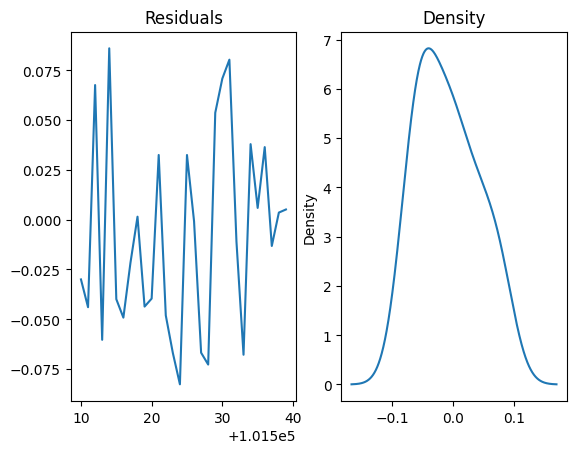

In [246]:
import matplotlib.pyplot as plt
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title = "Residuals", ax = ax[0])
residuals.plot(title = "Density", kind = "kde", ax = ax[1])
plt.show()

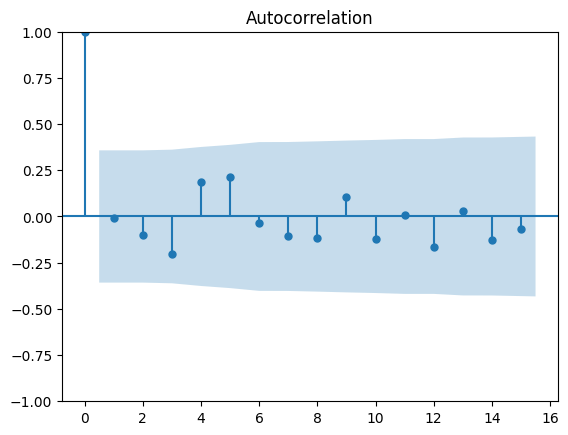

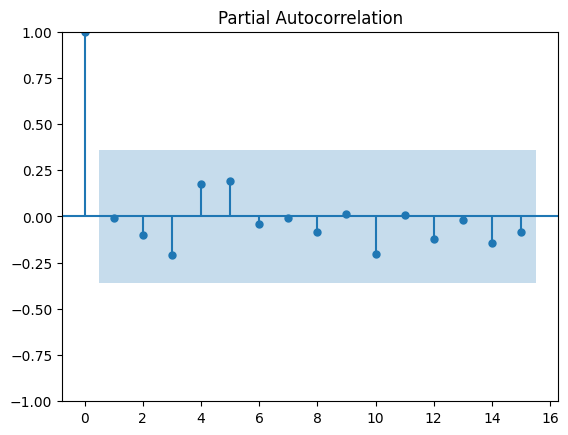

In [247]:
acf_res = plot_acf(residuals)
pacf_res = plot_pacf(residuals)

In [248]:
_test = testdfs[5]["Value"]

In [249]:
_test

107980    1.08
Name: Value, dtype: float64

In [250]:
forecast_test = model_fit.forecast(len(_test))

/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [251]:
forecast_test

31    1.29312
dtype: float64

In [252]:
import pmdarima as pm

In [253]:
auto_arima = pm.auto_arima(oceania, stepwise=False, seasonal=False)

In [254]:
auto_arima

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True)

In [255]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   31
Model:               SARIMAX(0, 1, 0)   Log Likelihood                  47.437
Date:                Sun, 29 Sep 2024   AIC                            -90.874
Time:                        10:52:11   BIC                            -88.072
Sample:                             0   HQIC                           -89.978
                                 - 31                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0077      0.010     -0.755      0.450      -0.028       0.012
sigma2         0.0025      0.001      2.561      0.010       0.001       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.68   Jarque-Bera (JB):                 2.12
Prob(Q):                              0.41   Prob(JB):                         0.35
Heteroskedasticity (H):               0.70   Skew:                             0.47
Prob(H) (two-sided):                  0.59   Kurtosis:                         2.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [256]:
forecast_test_auto = auto_arima.predict(n_periods=len(_test))

/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [257]:
forecast_test_auto

31    1.282333
dtype: float64

In [212]:
auto_arima.params

<bound method ARIMA.params of ARIMA(order=(1, 0, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)>

In [73]:
traindfs[1]

,Area Code,Area Code (M49),Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag,Note
103301,5300,'142,Asia,1357,Pesticides (total),5173,Use per value of agricultural production,1990,1990,g/Int$,0.72,E,NaN
103302,5300,'142,Asia,1357,Pesticides (total),5173,Use per value of agricultural production,1991,1991,g/Int$,0.69,E,NaN
103303,5300,'142,Asia,1357,Pesticides (total),5173,Use per value of agricultural production,1992,1992,g/Int$,0.68,E,NaN
103304,5300,'142,Asia,1357,Pesticides (total),5173,Use per value of agricultural production,1993,1993,g/Int$,0.67,E,NaN
103305,5300,'142,Asia,1357,Pesticides (total),5173,Use per value of agricultural production,1994,1994,g/Int$,0.67,E,NaN
103306,5300,'142,Asia,1357,Pesticides (total),5173,Use per value of agricultural production,1995,1995,g/Int$,0.67,E,NaN
103307,5300,'142,Asia,1357,Pesticides (total),5173,Use per value of agricultural production,1996,1996,g/Int$,0.66,E,NaN
103308,5300,'142,Asia,1357,Pesticides (total),5173,Use per value of agricultural production,1997,1997,g/Int$,0.65,E,NaN
103309,5300,'142,Asia,1357,Pesticides (total),5173,Use per value of agricultural production,1998,1998,g/Int$,0.61,E,NaN
103310,5300,'142,Asia,1357,Pesticides (total),5173,Use per value of agricultural production,1999,1999,g/Int$,0.61,E,NaN


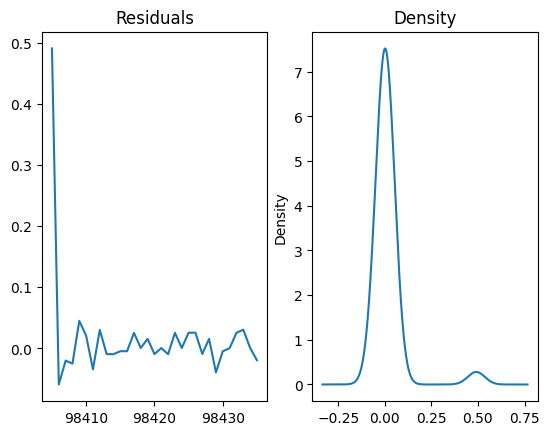

In [82]:
import matplotlib.pyplot as plt
residuals = auto_arima.resid()
fig, ax = plt.subplots(1,2)
residuals.plot(title = "Residuals", ax = ax[0])
residuals.plot(title = "Density", kind = "kde", ax = ax[1])
plt.show()

In [83]:
# work with the africa timeseries

In [84]:
africa = traindfs[0]["Value"]

In [85]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(africa)
print(f'p-value: {adf_test[1]}')

p-value: 0.22387709578732895


In [86]:
africa = africa.diff().dropna()

In [87]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(africa)
print(f'p-value: {adf_test[1]}')

p-value: 0.1381247898044516


In [88]:
africa = africa.diff().dropna()

In [89]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(africa)
print(f'p-value: {adf_test[1]}')

p-value: 1.656901873452554e-05


In [90]:
ps = [0,2,4,0,0,1,1] 
ds = [2,2,1,0,1,1,0]
qs = [0,3,0,0,0,1,0]

In [92]:
for i in range(len(testdfs)):
    print(testdfs[i]["Value"])

98436    0.53
Name: Value, dtype: float64
103332    0.46
Name: Value, dtype: float64
101988    1.1
Name: Value, dtype: float64
105772    0.88
Name: Value, dtype: float64
101540    1.29
Name: Value, dtype: float64
107980    1.08
Name: Value, dtype: float64
102884    2.63
Name: Value, dtype: float64


In [94]:
from statsmodels.tsa.arima.model import ARIMA

In [96]:
for i in range(len(ps)):
    continent = traindfs[i]["Value"]
    model = ARIMA(continent, order = (ps[i],ds[i],qs[i]))
    model_fit = model.fit()
    continent_test = testdfs[i]["Value"]
    forecast_test = model_fit.forecast(len(continent_test))
    print(forecast_test)

/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is av

31    0.52
dtype: float64
31    0.445063
dtype: float64
31    1.133447
dtype: float64
31    0.919995
dtype: float64
31    1.29
dtype: float64
31    1.205934
dtype: float64
31    2.509555
dtype: float64


/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [97]:
for i in range(len(ps)):
    continent = traindfs[i]["Value"]
    continent_test = testdfs[i]["Value"]
    auto_arima = pm.auto_arima(continent, stepwise=False, seasonal=False)
    forecast_test_auto = auto_arima.predict(n_periods=len(continent_test))
    print(forecast_test_auto)

/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


31    0.52464
dtype: float64


/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


31    0.455546
dtype: float64


/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


31    1.106139
dtype: float64


/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


31    0.85526
dtype: float64


/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


31    1.282333
dtype: float64


/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


31    1.216436
dtype: float64
31    2.574635
dtype: float64


/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
